# create and run a local Rag pipeline from scratch

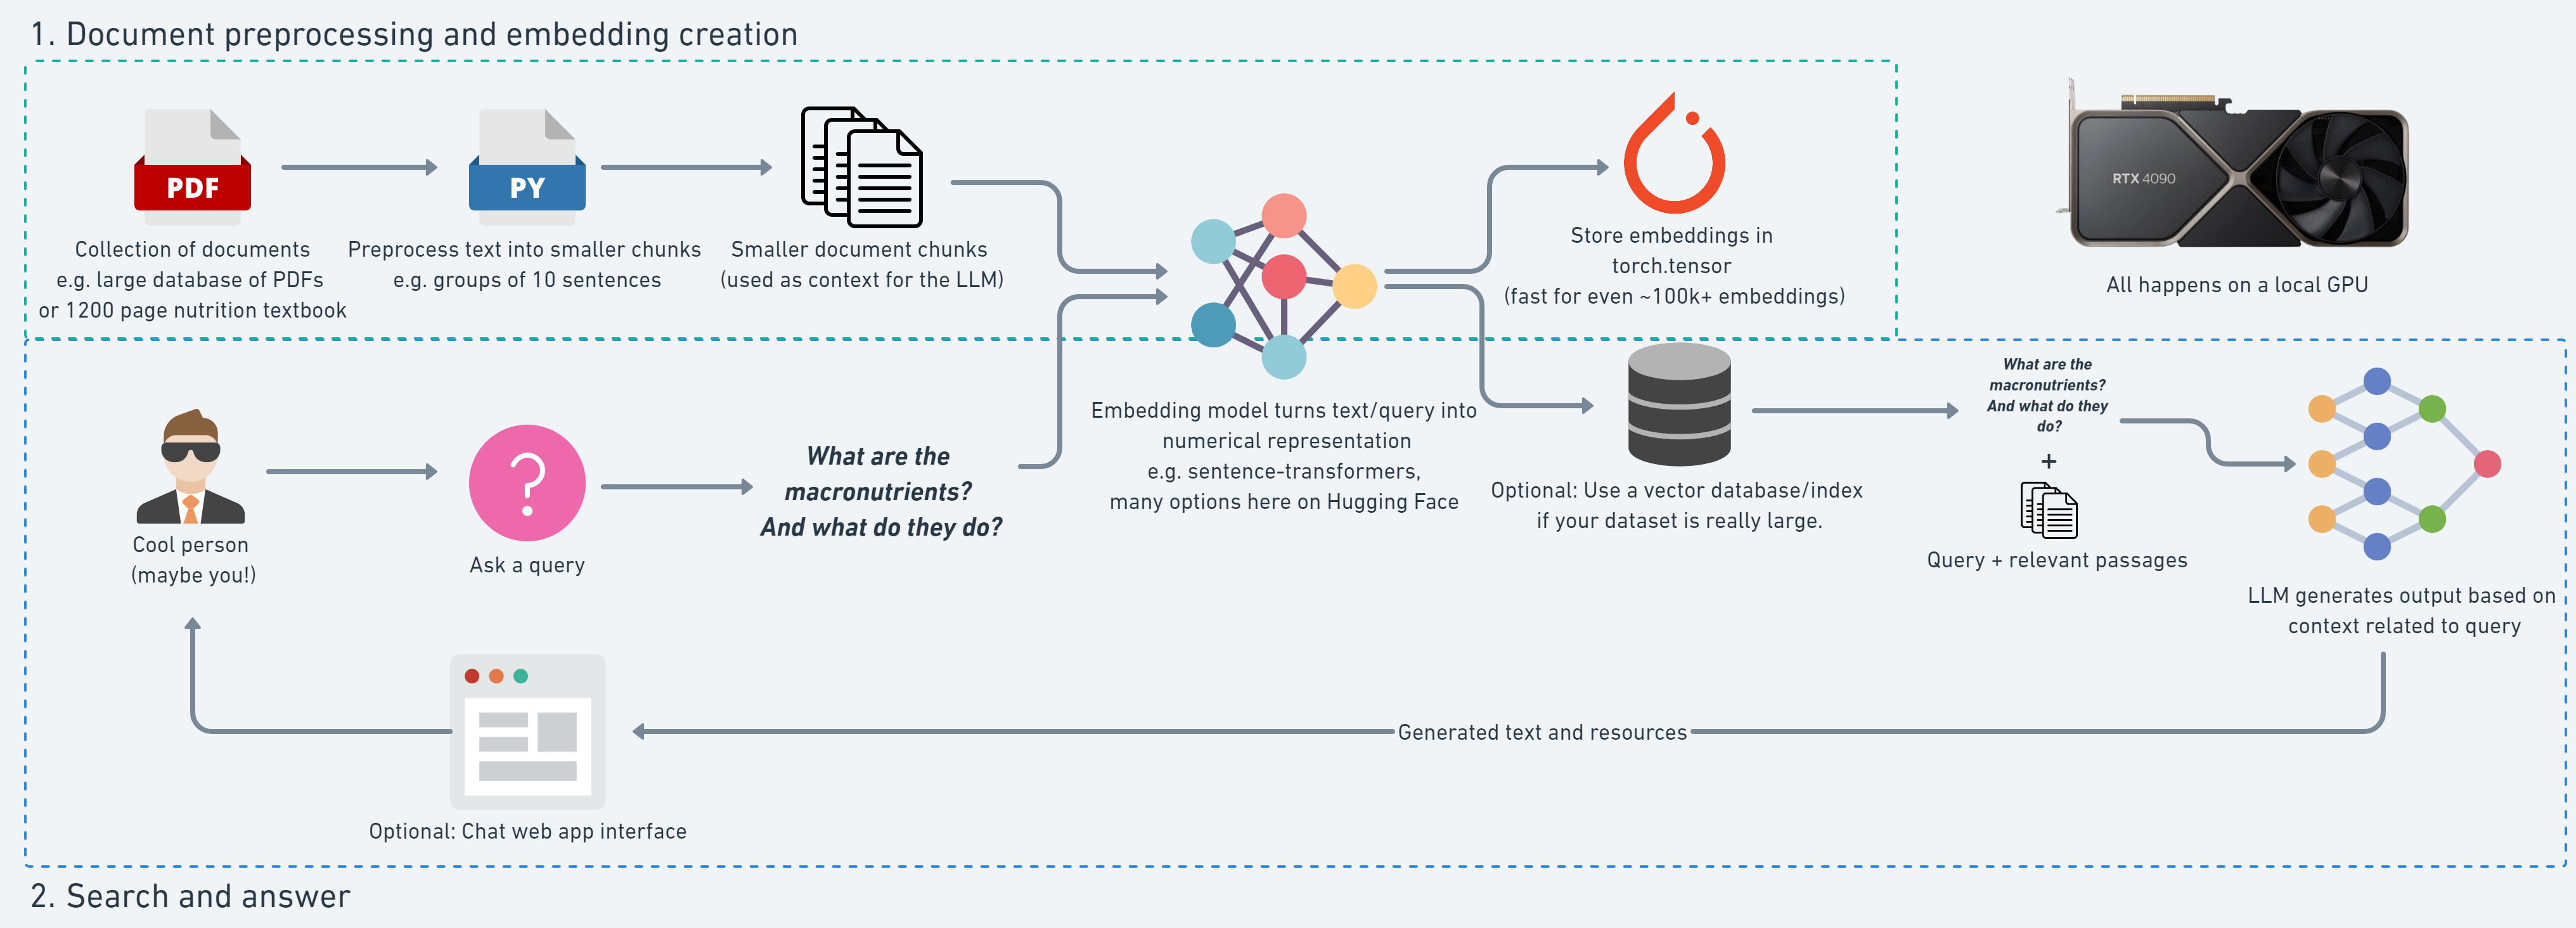

 ## read this


 - for more information :
 * https://github.com/mrdbourke/simple-local-rag/tree/main?tab=readme-ov-file

### here we use a book for testing
- Human-nutrition-text.pdf

In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 92.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


## what  we're going to build


We're going to build Nutrichat to "chat with a nutrition textbook"

specifically:

1. open a PDF document (use any pdf or collection of PDFs)
2. format the text of the PDF textbook ready for an embedding model
3. Embed all of the chunks of text in the textbook and turn into numerical
   representation (embedding) which can store for later.
4. Build a retrieval systtem that uses vector search to find relavant chunk of based on a query.
5. create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.


ALL locally!

1. step 1-3: Document preprocessing and embdding creation .
2. step 4-6: search and answer


## 1. Document/text processing anf embdding creation

Ingredients :

* Pdf document of choice.
* Embedding model of choice.

Steps:
1. Import Pdf document.
2. process text for embedding ( e.g. split into chunks pf sentence)
3. Embed text chunks with embedding model.
4. save embedding to file for later


### Import PDF document

In [ ]:
import os
import requests

# get PDF document path
pdf_path ="human-nutrition-text.pdf"



# download pdf if path not exixt

if not os.path.exists(pdf_path):
    print("[info] file doesn't exist , downloading......")


    # enter url
    url ="https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"



    #  the local filename to save the download file
    filename = pdf_path


    # senda Get requuest
    response = requests.get(url)


    if response.status_code == 200:
        # open the file and save it
        with open(filename,"wb") as file:
            file.write(response.content)
        print(f"[INFO] the file has been download and saved as {filename}")
    else:
        print(f"[INFO] failed to downlaod the file and the status code : {response.status_code}")
else:
    print(f" file  {pdf_path} already exist")


[info] file doesn't exist , downloading......
[INFO] the file has been download and saved as human-nutrition-text.pdf


We've got pdf , now open it

In [ ]:
import fitz   # requires PyMuPDF
from tqdm.auto import tqdm


def text_formatter(text: str) -> str:
    """Performs minor formatting on text"""
    cleaned_text = text.replace("\n"," ").strip()

    # more text formating can be done here

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_num , page in tqdm(enumerate(doc)):
        text = page.get_text()
        text=text_formatter(text=text)
        pages_and_texts.append({"page_number": page_num - 41,
                                "page_char_count": len(text),
                                "page_word_count" :len(text.split(" ")),
                                "page_sentence_count_row" : len(text.split(". ")),
                                "page_token_count" : len(text)/4,  # 1 toekn -> 4 char
                                "text":text
                                })
    return pages_and_texts


pages_and_text = open_and_read_pdf(pdf_path=pdf_path)
pages_and_text[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_row': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_row': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [ ]:
import random

random.sample(pages_and_text, k=3)

[{'page_number': 1050,
  'page_char_count': 1555,
  'page_word_count': 271,
  'page_sentence_count_row': 11,
  'page_token_count': 388.75,
  'text': 'The DASH Diet  The Dietary Approaches to Stop Hypertension, or DASH diet,  focuses on reducing sodium intake to either 2,300 milligrams per  day (as recommended by the Dietary Guidelines for Americans) or  1,500 milligrams per day for certain populations. The DASH diet  is an evidence-based eating plan that can help reduce high blood  pressure. This plan may also decrease the risk of heart attack,  stroke, diabetes, osteoporosis, and certain cancers.3  DASH tips to lower sodium include:  • Using spices instead of salt to add flavor  • Reading sodium content on processed or canned food labels,  and choosing low-sodium options  • Removing some sodium from canned foods (such as beans) by  rinsing the product before consumption  • Avoiding salt when cooking  DASH dieters are recommended to consume a variety of whole  grains and high-fiber fru

In [ ]:
import pandas as pd


df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


why token count is imp


1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.



for e.g. an embedding model may have been trained to embed sequence of 384 tokens into numerical space (sentence-transformer all-mpnet-base-v2)
see : https://huggingface.co/sentence-transformers/all-mpnet-base-v2?inference_provider=hf-inference

As for llms they can't accept infinite token in context window.




###  text processing
because of denser pages contains so many sentences
#### spliting pages in sentennces

two ways to do this

1. we've done this by splitting on ". "
2. we can do this  with a NLP library such as spaCy(https://spacy.io/) and  nltK(https://www.nltk.org/)





In [ ]:

from spacy.lang.en import English


nlp = English()

# add the sentencizer to the pipeline
nlp.add_pipe("sentencizer")

#create a document instance as an example

doc = nlp("this is the first sentence. This is the second sentence. And this is the third sentence!")

assert len(list(doc.sents)) == 3

# print out our sentences split by the sentencizer
list(doc.sents)

[this is the first sentence.,
 This is the second sentence.,
 And this is the third sentence!]

{'page_number': 190,
  'page_char_count': 1304,
  'page_word_count': 220,
  'page_sentence_count_row': 11,
  'page_token_count': 326.0,
  'text': 'Chloride  UNIVERSITY..'
  }

In [ ]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)


    # make sure all sentence are string (the default type is a spacy datatype)

    item["sentences"]= [str(sentence) for sentence in item["sentences"]]

    #count the number of sentences per page

    item["page_sentence_count"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_text, k=1)

[{'page_number': 324,
  'page_char_count': 1968,
  'page_word_count': 336,
  'page_sentence_count_row': 13,
  'page_token_count': 492.0,
  'text': 'Carbohydrates chapter.\xa0The body transforms carbohydrates into  glycogen that is in turn stored in the muscles for energy. When  the muscles reach their capacity for glycogen storage, the excess  is returned to the liver, where it is converted into triglycerides and  then stored as fat.  In a similar manner, much of the triglycerides the body receives  from food is transported to fat storehouses within the body if not  used for producing energy. The chylomicrons are responsible for  shuttling the triglycerides to various locations such as the muscles,  breasts, external layers under the skin, and internal fat layers of the  abdomen, thighs, and buttocks where they are stored by the body  in adipose tissue for future use. How is this accomplished? Recall  that chylomicrons are large lipoproteins that contain a triglyceride  and fatty-acid 

In [ ]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,page_sentence_count
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### chunking our sentences together

the concept of splitting larger pieces into smaller ones is often referred to as text splitting or chunking .

there is  no 100% correct way to do this.

we'll keep it simple and split into group of 10 sentences -> change if needed like 5,7,9... etc

there are framework langchain  -> use it if needed


for now we use pthon only


why we do this :
1. so our texts are easier to filter
2. so our  text chunks can fit into our embedding model context window -> 384 tokens as a limit
3. so our contexts passed to an LLm can be more specific and focused.

In [ ]:
# define split size to turn groups of sentences into chunks

num_sentence_chunk_size = 10

# create a funtion that split list of text recursively into chunks of size

def split_list(input_list: list[str], slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]



test_list = list(range(25))

split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
# Loop through pages and texts and spilts sentences into chunks

for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(item['sentences'], slice_size=num_sentence_chunk_size)
    item['sentence_chunk_count'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_text, k=1)

[{'page_number': 679,
  'page_char_count': 785,
  'page_word_count': 199,
  'page_sentence_count_row': 19,
  'page_token_count': 196.25,
  'text': 'Food  Serving Selenium (mcg) Percent Daily Value  Brazil nuts  1 oz.  544  777  Shrimp  3 oz.  34  49  Crab meat  3 oz.  41  59  Ricotta cheese  1 c.  41  59  Salmon  3 oz.  40  57  Pork  3 oz.  35  50  Ground beef  3 oz.  18  26  Round steak  3 oz.  28.5  41  Beef liver  3 oz.  28  40  Chicken  3 oz.  13  19  Whole-wheat bread 2 slices 23  33  Couscous  1 c.  43  61  Barley, cooked  1 c.  13.5  19  Milk, low-fat  1 c.  8  11  Walnuts, black  1 oz.  5  7  Source: US Department of Agriculture, Agricultural Research  Service. 2010. USDA National Nutrient Database for Standard  Reference, Release 23. http://www.ars.usda.gov/ba/bhnrc/ndl.  Learning Activities  \xa0 Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  Selenium  |  679',
  'sentences': ['Food  Serving Selenium (mcg) Percent Daily V

In [ ]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,page_sentence_count,sentence_chunk_count
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### splitting each chunk into its own item


we'd like embed each chunk of setennce into own numnerical representation.

that'll give us a good level of granularity

Meaning , we can dive specificaaly into text sample that was used in our model .



In [ ]:
import re

# split each chunk into its own item

pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']


        # join the sentences back into a paragraph like structure
        joined_sentence_chunk = "".join(sentence_chunk).replace("  "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A" (will work for any captial letter)


        chunk_dict["sentence_chunk"] = joined_sentence_chunk


        # get some stats on our chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in  joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4  # 1 token -> 4 char


        pages_and_chunks.append(chunk_dict)


len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 756,
  'sentence_chunk': 'Fruit and Vegetable Intake among Adolescents and Adults in the United States: Percentage Meeting Individualized Recommendations. Medscape Journal of Medicine, 11(1), 26. http://www.ncbi.nlm.nih.gov/pmc/articles/ PMC2654704/?tool=pubmed. Accessed November 22, 2017. 756 | MyPlate Planner',
  'chunk_char_count': 286,
  'chunk_word_count': 32,
  'chunk_token_count': 71.5}]

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### filter chunks of text for short chunks


these chunks may not contain much useful information

In [ ]:
# show random chunks with 30 tokens in length

min_token_length = 30

for row in df[df['chunk_token_count'] <= min_token_length].sample(5).iterrows():
    print(f"chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

chunk token count: 27.0 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=165 226 | Popular Beverage Choices
chunk token count: 14.75 | Text: Folate is also found in legumes, liver, and Pregnancy | 787
chunk token count: 19.75 | Text: PART XVIII CHAPTER 18. NUTRITIONAL ISSUES Chapter 18. Nutritional Issues | 1041
chunk token count: 17.5 | Text: The Obesity Myth. Gotham Books. Calories In Versus Calories Out | 1069
chunk token count: 27.75 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=144 Regulation of Water Balance | 171


In [ ]:
# filter  out chunks with less than 30 tokens


pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]


[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [ ]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 549,
  'sentence_chunk': 'Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=331 \xa0 Fat-Soluble Vitamins | 549',
  'chunk_char_count': 736,
  'chunk_word_count': 104,
  'chunk_token_count': 184.0}]

### Embedding our text chunks

Embedding are a broad but powerful concept


while humans understand text , machine understand numbers.

what we'd like to do :
- turn our text chunks into numbers , specifically embeddings.

A useful numerical representation.


The best part about embedding is that are a *learned* representation.

{
    "the": 0,
    "a" : 1,
    ...
    ...

}

for a great resource on learning embedding , see here :https://vickiboykis.com/what_are_embeddings/



In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda")  # change to "cuda" if you have a GPU available

# create a list of sentences

sentences = [" the sentence transformer library provides an easy way to compute embeddings for sentences",
             " you can use a variety of pre-trained models to generate embeddings",
             "i love programming in java"]

# sentences are encoded/ embedded by calling the model's encode method
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))


#see the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}\nEmbedding: {embedding}\n\n")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence:  the sentence transformer library provides an easy way to compute embeddings for sentences
Embedding: [-5.24701877e-03  3.99931632e-02 -2.43992340e-02  7.00516775e-02
 -3.89326699e-02  1.72437988e-02 -1.50064158e-03 -5.06277122e-02
  2.89696967e-04 -3.56433317e-02  3.21496055e-02  2.48738956e-02
 -2.86433119e-02  5.50020020e-03  2.95926444e-02 -3.34383547e-02
  4.00993004e-02  1.11746816e-02 -3.95987276e-03  2.65422221e-02
  1.73943304e-02  2.23162547e-02  1.45632178e-02  5.32848313e-02
 -1.50239496e-02 -4.15329039e-02  4.94623231e-03 -1.07226549e-02
  5.77456430e-02  5.67450980e-03 -3.74217774e-03  2.52733449e-03
  2.98702642e-02  4.02873661e-03  1.04985111e-06 -7.12676207e-04
 -1.79938581e-02 -2.03975514e-02  1.06762061e-02  1.76953077e-02
  6.20997101e-02 -5.91757894e-02  2.39446517e-02  2.27179918e-02
 -6.17324673e-02  4.37374087e-03  3.66579331e-02  4.04625945e-02
  5.90864383e-02  6.06044568e-02 -1.78147536e-02 -5.63945398e-02
 -2.94293207e-03  2.85431789e-03 -4.4135139

In [ ]:
embeddings[0].shape  # each embedding is a 768 dimensional vector

(768,)

In [ ]:
embedding = embedding_model.encode("My favorite food is pizza.")
embedding

array([-4.28960212e-02,  1.24895498e-01, -2.69699912e-03, -9.82209388e-03,
        5.47989793e-02,  2.71454714e-02, -8.16602781e-02,  3.63265872e-02,
        1.37068518e-02,  3.01814023e-02, -3.14055979e-02,  2.58790888e-02,
        1.80916749e-02,  3.19366492e-02, -3.66341919e-02, -6.57801097e-03,
        7.62857497e-03,  2.88835019e-02,  4.52913977e-02,  5.34031577e-02,
       -2.75081228e-02,  3.36303301e-02, -4.22045356e-03, -1.03346473e-02,
       -3.85347232e-02, -3.54054268e-03,  1.23274392e-02, -5.13157323e-02,
       -2.05110647e-02,  3.67983542e-02, -7.36730872e-03, -3.08692008e-02,
       -3.06861196e-02, -3.30124795e-02,  1.56614351e-06,  1.45957032e-02,
       -1.08528351e-02,  1.81191415e-02,  1.89672317e-03,  1.81095339e-02,
       -1.49862738e-02, -3.69406166e-03, -4.26550172e-02, -4.72181989e-03,
       -2.12225020e-02, -8.91110860e-03,  4.61955462e-03,  6.49265647e-02,
       -3.93161289e-02,  2.59754807e-02,  1.21477675e-02, -9.37857479e-02,
       -7.05341995e-02,  

In [ ]:
%%time

embedding_model.to("cuda")  # change to "cuda" if you have a GPU available


# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 28.3 s, sys: 176 ms, total: 28.5 s
Wall time: 28.9 s


In [ ]:
%%time


text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 531 µs, sys: 0 ns, total: 531 µs
Wall time: 587 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [ ]:
len(text_chunks)

1680

In [ ]:
%%time

#Embedd all text in batches

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32) # experiment for better result


text_chunk_embeddings

CPU times: user 23.9 s, sys: 43.2 ms, total: 23.9 s
Wall time: 23.4 s


array([[ 0.06742427,  0.09022819, -0.0050955 , ..., -0.02211547,
        -0.02321368,  0.01256907],
       [ 0.05521561,  0.05921394, -0.01661672, ..., -0.01204061,
        -0.01028473,  0.02273969],
       [ 0.02798017,  0.03398143, -0.02064266, ..., -0.00536188,
         0.02125599,  0.03130551],
       ...,
       [ 0.07705159,  0.00978557, -0.01218174, ..., -0.04086803,
        -0.0751763 , -0.02405259],
       [ 0.10304508, -0.01647023,  0.00826846, ..., -0.05742176,
        -0.02828035, -0.02946862],
       [ 0.08637746, -0.01253584, -0.01127464, ..., -0.05223799,
        -0.03367292, -0.02986602]], dtype=float32)

### save embeddings to file

In [ ]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [ ]:
# save embeddings to file

text_chunk_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embedding_df_save_path = "text_chunk_and_embeddings_df.csv"

text_chunk_embeddings_df.to_csv(embedding_df_save_path, index=False)

In [ ]:
# import saved file and view

text_chunk_and_embeddings_df_load = pd.read_csv(embedding_df_save_path)
text_chunk_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


if your embedding is really large -> vector db


### Chunking and embedding questions
*Which embedding model should I use?*

This depends on many factors. My best advice is to experiment, experiment, experiment!

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware.

A good place to see how different models perform on a wide range of embedding tasks is the Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard.

*What other forms of text chunking/splitting are there?*

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, Pinecone has a great guide on different kinds of chunking including for different kinds of data such as markdown and LaTeX.

Libraries such as LangChain also have a good amount of in-built text splitting options.

*What should I think about when creating my embeddings?*

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:

Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.
*Where should I store my embeddings?*

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), np.array or torch.tensor can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a vector database (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions
One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.

### 2. RAG - Search and Answer
We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:

- Retrieval - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
- Augmentation - LLMs are capable of generating text given a prompt. However, this generated text is designed to look right. And it often has some correct information, however, they are prone to hallucination (generating a result that looks like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
- Generation - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).
The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How?

It starts with better search

### similarity search

Embedding can be used for almost any type of data.

comparing enbedding is known as Similarity Search , vector search , semnatic search , etc....


In our  case , we want to query our nutrition textbook passsages based on semantics or "vibes"

so if I search for "macronotrients functions" I should get relavant passage to that text buy may not containn exactly the words "macronutrient functions"

whereas with keyword search , if I search "apple" I get back passages with specifically "apple".




In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# import text and embeddings dataframe
text_chunk_and_embeddings_df = pd.read_csv("text_chunk_and_embeddings_df.csv")


#convert embedding string back to numpy array
text_chunk_and_embeddings_df["embedding"] = text_chunk_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

#convert our embedding to torch tensor

embeddings = torch.tensor(np.stack(text_chunk_and_embeddings_df['embedding'].tolist(),axis=0),dtype=torch.float32).to(device)



# convert text and embedding df to list of dict
pages_and_chunks= text_chunk_and_embeddings_df.to_dict(orient="records")

text_chunk_and_embeddings_df


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [ ]:

embeddings.shape

torch.Size([1680, 768])

In [ ]:
# create model

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)  # change to "cuda" if you have a GPU available


Embedding model ready !

lets create a semantic search pipeline

In esssence ,we want to search for a query ( e.g. "macronutrient funtions") and get back relavant passages from our text book


we can do so with following steps:

1. define a query string.
2. turn the query string into an embedding
3. perform a dot prodoct or cosine similarity funtion between the text embeddings and the query embedding.
4. Sort the result from 3 in descending order.

Note : to use dot product for comparison ,ensure vector sizes are of same shape (e.g. 768) and tensor/vectors are in the same datatype ( e.g both are in torch.float32)

In [ ]:
# 1. define a query
query = "macronutrients functions"

print(f"query: {query}")

# 2. embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# get similarity score with the dot product  ( use cosine  similarity if output of model aren't normalized)

from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

end_time = timer()

print(f"[INFO] Time taken to calculate similarity scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")


# 4. get top k results ( we'll keep top  5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

query: macronutrients functions
[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.02140 seconds


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [ ]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

we can see that searching over embedding is very fast even if we do exhaustive search.

But if u had 10M+ embeddings , you likely want to create an index


An index is like letters in the dictionary.

for example , if u want to search "duck" in the dictionary , you'd star at "d" then find words close to "du.." etc.


Amn index -> helps  to narrow it down

A popular indexing library for vector search id Faiss .  -> by facebbok - https://github.com/facebookresearch/faiss

one technique that library provide is approximate nearest neighbour search (ANN) - https://en.wikipedia.org/wiki/Nearest_neighbor_search



In [ ]:
import textwrap

def print_wrapped(text, width=80):
    wrapper = textwrap.TextWrapper(width=width)
    wrapped_text = wrapper.fill(text=text)
    print(wrapped_text)

In [ ]:
print(f"query: {query}\n")
print("Results ")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n---\n")

query: macronutrients functions

Results 
Score: 0.6926
Text
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are mol

Note  : we could potentially improve the order of these results with *reranking* model . A model that has been trained specifically to take search results
(e.g the top 25 semantic results) and rank them in order from most likely  top-1 to least likely.


See here for an open-source reranking model: https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

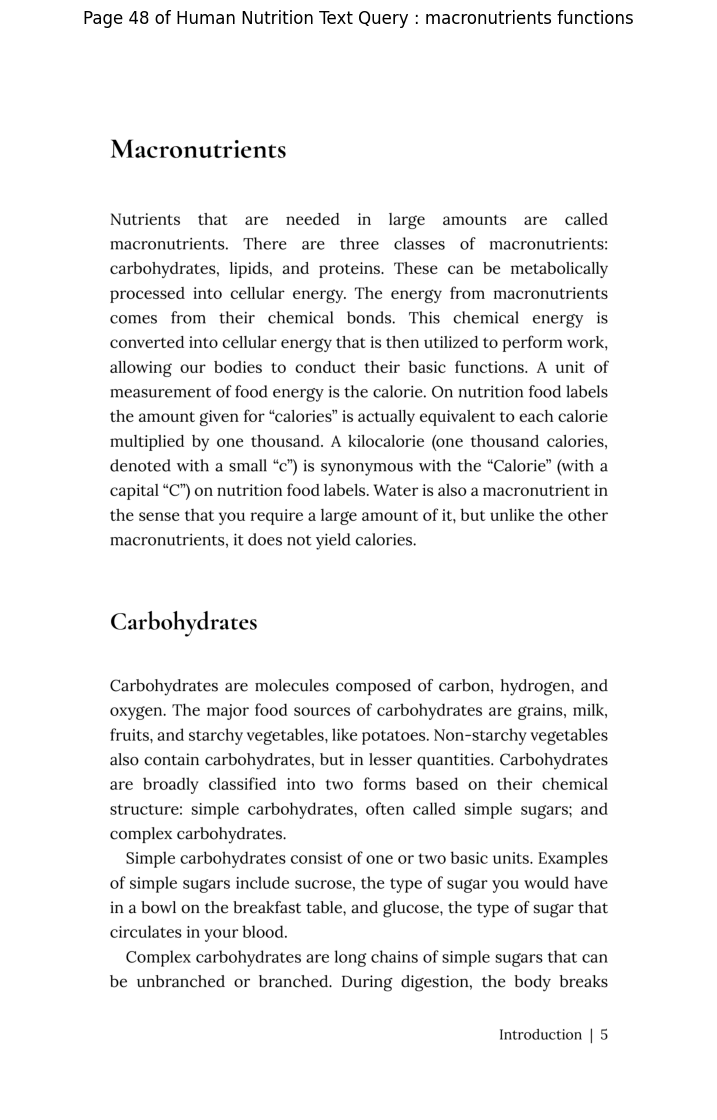

In [ ]:
import fitz   # requires PyMuPDF


#open pdf and load target

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
doc = fitz.open(pdf_path)

page = doc.load_page(5 + 41)  # page number 48

#get the image of the page

img = page.get_pixmap(dpi =300)

#save it -> optional
# img.save("page-48.png")

doc.close()


#convert to pixmap to a numpy array
img_array = np.frombuffer(img.samples, dtype=np.uint8).reshape(img.height, img.width, img.n)

# dusplay the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 14))
plt.imshow(img_array)
plt.title(F"Page 48 of Human Nutrition Text Query : {query}")
plt.axis("off")

plt.show()

### similarity measures : dot product and cosine similarities

Two of the most common similarirty messures between vectors  are dot product and cosine similarity.

In essence , closer vectors will have scores ,further away vectors will have lower scores.

Vectors have direction and magnitude .

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### funtion izing our semanctic search pipeline

Let's put all of the steps from above for semantic search into a funtionor two so we can repeat the workflow.


In [ ]:
def retrive_relavant_resource(query: str,
                            embeddings: torch.Tensor,
                            model: SentenceTransformer=embedding_model,
                            print_time: bool=True,
                            top_k: int=5,):
    """Retrive relavant resource from a query"""

    # 1. embed the query
    query_embedding = model.encode(query, convert_to_tensor=True).to(device)

    start_time = timer()

    # 2. get similarity score with the dot product  ( use cosine  similarity if output of model aren't normalized)
    dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]


    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to calculate similarity scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")



    # 3. get top k results ( we'll keep top  5)
    scores , indices = torch.topk(dot_scores, k=top_k)

    return scores, indices



def print_top_results_and_scores(query: str,
                                 embeddings: torch.Tensor,
                            pages_and_chunks: list[dict]=pages_and_chunks,
                            top_k: int=5):
    """Print top results and scores"""
    scores, indices = retrive_relavant_resource(query=query,
                                               embeddings=embeddings,
                                               top_k=top_k)

    print(f"query: {query}\n")
    print("Results ")
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text")
        print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n---\n")

In [ ]:
query="vitamins and minerals"


retrive_relavant_resource(query=query, embeddings=embeddings)

print_top_results_and_scores(query=query, embeddings=embeddings)



[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.00008 seconds
[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.00008 seconds
query: vitamins and minerals

Results 
Score: 0.6534
Text
Learning Activities Technology Note: The second edition of the Human Nutrition
Open Educational Resource (OER) textbook features interactive learning
activities.  These activities are available in the web-based textbook and not
available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open
Document). Learning activities may be used across various mobile devices,
however, for the best user experience it is strongly recommended that users
complete these activities using a desktop or laptop computer and in Google
Chrome.   An interactive or media element has been excluded from this version of
the text. You can view it online here: http://pressbooks.oer.hawaii.edu/
humannutrition2/?p=372   An interactive or media element has been excluded from
this ve

### getting an LLm for local generation

all things we are done here is local.



In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.

import torch

if torch.cuda.is_available():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"Available GPU memory: {gpu_memory_gb} GB")

    if gpu_memory_gb < 5.1:
        print(f"GPU memory: {gpu_memory_gb} GB | Not enough for Gemma 7B. Use Gemma 2B in 4-bit.")
        use_quantization_config = True
        model_id = "google/gemma-2b-it"
    elif gpu_memory_gb < 8.1:
        print(f"GPU memory: {gpu_memory_gb} GB | Recommended: Gemma 2B in 4-bit precision.")
        use_quantization_config = True
        model_id = "google/gemma-2b-it"
    elif gpu_memory_gb < 19.0:
        print(f"GPU memory: {gpu_memory_gb} GB | Recommended: Gemma 2B FP16 or Gemma 7B in 4-bit.")
        use_quantization_config = False
        model_id = "google/gemma-2b-it"
    else:
        print(f"GPU memory: {gpu_memory_gb} GB | Recommended: Gemma 7B (4-bit or FP16).")
        use_quantization_config = False
        model_id = "google/gemma-7b-it"

else:
    print("⚠️ No GPU detected. Running on CPU only.")
    print("Recommended: Gemma 2B in 4-bit quantization for reasonable performance.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")


Available GPU memory: 15 GB
GPU memory: 15 GB | Recommended: Gemma 2B FP16 or Gemma 7B in 4-bit.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


We can load an LLM locally using Hugging Face transformers.

The model I'm going to use on my NVIDIA RTX 4090 - https://huggingface.co/google/gemma-7b-it

To get a model running local we're going to need a few things:

1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
2. A model ID - this will tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
4. An LLM model - this will be what we use to generate text based on an input!
Note: There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention

In [ ]:
from huggingface_hub import login

# Paste your token inside quotes
login("hf_xxx")

## Loading an LLM locally
We can load an LLM locally using Hugging Face transformers.

The model I'm going to use on my NVIDIA RTX 4090 - https://huggingface.co/google/gemma-7b-it

To get a model running local we're going to need a few things:

- A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
- A model ID - this will tell transformers which model/tokenizer to load
- A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
- An LLM model - this will be what we use to generate text based on an input!
Note: There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the GitHub for more: https://github.com/Dao-AILab/flash-attention

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use
# model_id = "google/gemma-7b-it"
model_id = model_id

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

Using attention implementation: sdpa


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
torch.cuda.get_device_capability(0)[0]

7

In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    """Get the number of parameters in a model"""
    return sum(p.numel() for p in model.parameters())


get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_num_size(model : torch.nn.Module):
  #get model paramters and buffer size
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buffer.nelement() * buffer.element_size() for buffer in model.buffers()])

  #calculate model size
  model_mem_bytes = mem_params + mem_buffers
  model_mem_gb = model_mem_bytes / (1024**3)
  model_mem_mb = model_mem_bytes / (1024**2)


  return {"model_mem_bytes" : model_mem_bytes,
          "model_mem_mb":round(model_mem_mb,2),
          "model_mem_gb":round(model_mem_gb,2)}

get_model_num_size(llm_model) # -> approx 4.67GB vram needed

{'model_mem_bytes': 5012345344, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

we got the size of our model

This mean to load Gemma--> in float16 we need minimum of 4.67GB+ VRAM,
however due to the calculations that take place in the forward pass, we actually need closer  to more appox 5 + 3GB


# Generate text with our LLM


* Note : Some models have been trained /tuned to generate text with a specific template in mind.


Becuase gemma -> has been trained in an instruction-tuned manner , we should follow the instruction template for the best results.

In [ ]:
input_text = "what are the micronutrients ,and what roles they play in the human body ?"
print(f"Input text: \n{input_text}\n")

# create prompt template for instruction tuned model
dialogue_template = [
    {"role": "user", "content": input_text}
]

# Apply the chat template and get back a string
prompt = tokenizer.apply_chat_template(
    conversation=dialogue_template,
    tokenize=False,
    add_generation_prompt=True
)

print(f"Prompt(formatted):\n {prompt}")


Input text: 
what are the micronutrients ,and what roles they play in the human body ?

Prompt(formatted):
 <bos><start_of_turn>user
what are the micronutrients ,and what roles they play in the human body ?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn into into number and send it to the GPU)

input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")


# Generate output from local llm

outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)

print(f"Model output (token):\n {outputs[0]}\n")

Model output (token):
 tensor([     2,      2,    106,   1645,    108,   5049,    708,    573,  92800,
        184592,   1688,    639,   1212,  16065,    984,   1554,    575,    573,
          3515,   2971,   1654,    107,    108,    106,   2516,    108,  21404,
        235269,   1517, 235303, 235256,    476,  13367,    576,    573,  92800,
        184592,    578,   1024,  16065,    575,    573,   3515,   2971, 235292,
           109,    688,   5057,   1695, 184592,    688,    708,  37132,    674,
           573,   2971,   2952, 156734,    611,   1277,   1997,    578,   2004,
           614,   7034,    774,    573,  11652, 235265,   2365,    708,   8727,
           604,   4282,  55786,   7257, 235269,   3359, 235292,    109,    688,
        235274, 235265,  10367,   4584,  66058,    108, 235290,  37773,    599,
        235274, 235284,    603,  20305,    604,    573,   4584,    576,   3118,
          5330,   5999, 235269,    948,   6383,  16175,   6900,    573,   2971,
        235265,  

In [ ]:
# decode the output tokens to text

outputs_decoded = tokenizer.decode(outputs[0])

print(f"Model output (text):\n {outputs_decoded}")

Model output (text):
 <bos><bos><start_of_turn>user
what are the micronutrients ,and what roles they play in the human body ?<end_of_turn>
<start_of_turn>model
Sure, here's a summary of the micronutrients and their roles in the human body:

**Micronutrients** are nutrients that the body cannot synthesize on its own and must be obtained from the diet. They are essential for various bodily functions, including:

**1. Energy production:**
- Vitamin B12 is crucial for the production of red blood cells, which carry oxygen throughout the body.
- Vitamin A is essential for the synthesis of visual pigments in the eyes.

**2. Bone and teeth health:**
- Calcium and phosphorus from dairy products, leafy greens, and fortified foods contribute to strong bones and teeth.
- Vitamin D helps the body absorb calcium and phosphorus.

**3. Immune function:**
- Vitamin C, found in citrus fruits and vegetables, boosts the immune system and protects against infections.
- Vitamin A is essential for the produc

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrive_relavant_resource(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.00012 seconds


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

### Augementing our prompt with context items
We've done retrieval.

We've done generation.

Time to augment!

The concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out.

However, there are a fair few techniques that work quite well.

Resources:

https://www.promptingguide.ai/
https://github.com/brexhq/prompt-engineering
https://www.anthropic.com/news/prompt-engineering-for-business-performance
We're going to use a couple of prompting technqiues:

Give clear instructions.
Give a few examples of input/output (e.g. given this input, I'd like this output).
Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...".
Let's create a function to format a prompt with context items.

In [ ]:

def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)

    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrive_relavant_resource(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Describe the process of digestion and absorption of nutrients in the human body.
[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.00011 seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells 

In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text, the higher the value, the more creative
                             do_sample=True, # whether or not to use sampling, https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Describe the process of digestion and absorption of nutrients in the human body.
RAG answer:
<bos>Sure, here's the relevant passage from the context:

>The process of digestion begins even before you put food into your mouth. When you feel hungry, your body sends a message to your brain that it is time to eat. Sights and smells influence your body’s preparedness for food. Smelling food sends a message to your brain. Your brain then tells the mouth to get ready, and you start to salivate in preparation for a meal. Once you have eaten, your digestive system (Figure 2.4 “The Human Digestive System”) starts the process that breaks down the components of food into smaller components that can be absorbed and taken into the body.

The digestive system is one of the eleven organ systems of the human body, and it is composed of several hollow tube-shaped organs including the mouth, pharynx, esophagus, stomach, small intestine, large intestine (colon), rectum, and anus. It is lined with m

### Functionize our LLM answering feature
Wouldn't it be cool if our RAG pipeline worked from a single function?

E.g. you input a query and you get a generated answer + optionally also get the source documents (the context) where that answer was generated from.

Let's make a function to do it!


In [ ]:
def ask(query: str,
        temperature: float = 0.7,
        max_new_tokens: int = 256,
        format_answer_text: bool = True,
        return_answer_only: bool = True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    scores, indices = retrive_relavant_resource(query=query,
                                                 embeddings=embeddings)

    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    prompt = prompt_formatter(query=query, context_items=context_items)

    # GENERATION
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(
        **input_ids,
        temperature=temperature,
        do_sample=True,
        max_new_tokens=max_new_tokens
    )

    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if format_answer_text:
        output_text = output_text.strip()

    if return_answer_only:
        return output_text
    else:
        return output_text, context_items



In [ ]:
# Example usage
query = random.choice(query_list)
print(f"Query: {query}")
answer, ctx = ask(query=query, temperature=0.7, return_answer_only=False)
print("Answer:", answer)
print("Context used:", ctx)

Query: How often should infants be breastfed?
[INFO] Time taken to calculate similarity scores on 1680 embeddings: 0.00011 seconds
Answer: user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting

### Summary
RAG = powerful technique for generating text based on reference documents.
Doesn't have to be too complicated to setup. We've just built one from scratch running on our local machines that can run in 3-4 functions.
Hardware use = use GPU where possible to accelerate embedding creation and LLM generation.
Keep in mind the limitations on your local hardware.
Many open-source embedding models and LLMs starting to became available, keep experimenting to find which is best.
Semantic search is a really helpful tool.